In [1]:
from topological_codes import RepetitionCode
from qiskit import Aer, QuantumCircuit
import numpy as np

We are going to insert an RB sequence into a $d=3$ repetition code with two syndrome measurement rounds.

We start by creating a code without any syndrome measurements.

In [2]:
d = 3

xbasis = False # you can choose whether to detect bit flip errors (False) or phase flip errors (True)

code = RepetitionCode(d,0,xbasis=xbasis)

Then we add in a single round of syndrome measurememts.

In [3]:
code.syndrome_measurement()

Now we'll add the RB sequence. This will be done on the middle qubit, which is

In [4]:
q = code.circuit['0'].qregs[1][int(d/2)]

Let's suppose we have been given an RB sequence as a 1 qubit, 1 bit circuit that ends in a measurement.

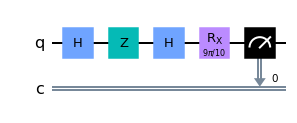

In [5]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.z(0)
qc.h(0)
qc.rx(0.9*np.pi,0)
qc.measure(0,0)

qc.draw(output='mpl')

We can then copy this to a new circuit, but without the measurement and the bit.

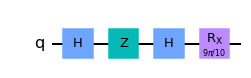

In [6]:
new_qc = QuantumCircuit()

for qreg in qc.qregs:
    new_qc.add_register(qreg)
    
for gate in qc.data:
    if gate[0].name!='measure':
        new_qc.data.append(gate)
        
new_qc.draw(output='mpl')

The code has two circuits: one for a stored `0` and the other for a stored `1`. We'll apply the RB sequence to both. Here is a simple example one, which includes a slightly imperfect x gate.

In [7]:
for logical in ['0', '1']:

    code.circuit[logical] = code.circuit[logical].compose(new_qc,[q])

Now we finish off the circuit with another syndrome measurement and final readout.

In [8]:
code.syndrome_measurement()
code.readout()

Here's the circuit for logical `0`.

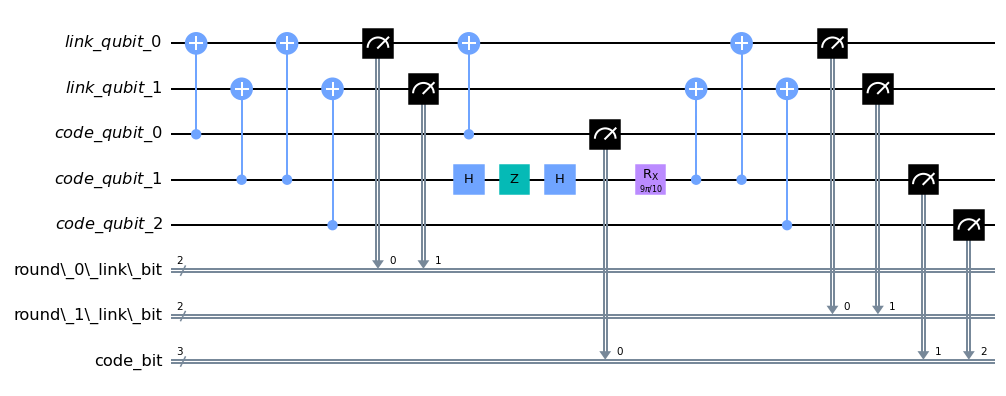

In [9]:
code.circuit['0'].draw(output='mpl')

Now let's run it on a simulator.

In [10]:

# set up the backend
backend = Aer.get_backend('aer_simulator')

# get the circuits as a list
circuits = code.get_circuit_list()

# run them
job = backend.run(circuits)

Now we'll look at the probability that something went wrong. For the logical `0`, the signature of nothing going wrong is the output `000 00 00`,and the signature of an error only on the circuit `q` at the time of the RB sequence is `010 11 00` (note: these are true only for `d=3`). If the probability of an error at this time is $p$, then

$$
\frac{p}{1-p} = \frac{s_\mathtt{010 11 00}}{s_\mathtt{000 00 00}},
$$

where $s_\mathtt{000 00 00}$ is the number of shots for which the output is `000 00 00`, etc.

For logical `1`, the error-free output is `111 00 00`, and the RB only error is `101 11 00`.

The following can therefore be used to determine the error probabilities.

In [11]:
# we
p = {}

# logical 0
counts = job.result().get_counts(0)
if '010 11 00' in counts:
    r = counts['010 11 00']/counts['000 00 00']
    p['0'] = r/(1+r)
else:
    p['0'] = 0
    
# logical 1
counts = job.result().get_counts(1)
if '101 11 00' in counts:
    r = counts['101 11 00']/counts['111 00 00']
    p['1'] = r/(1+r)
else:
    p['1'] = 0

So let's see what error our imperfect `x` caused.

In [12]:
p

{'0': 0.025390625, '1': 0.01953125}

In [13]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
#Run on noisy simulator

noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [14]:
noisy_backend = Aer.get_backend('aer_simulator')
noisy_circuit = code.get_circuit_list()
noisy_job = backend.run(noisy_circuit,noise_model=noise_model,max_parallel_experiments=0)

In [15]:
# we
noisy_p = {}

# logical 0
noisy_counts = noisy_job.result().get_counts(0)
if '010 11 00' in noisy_counts:
    noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
    noisy_p['0'] = noisy_r/(1+noisy_r)
else:
    noisy_p['0'] = 0
    
# logical 1
noisy_counts = noisy_job.result().get_counts(1)
if '101 11 00' in noisy_counts:
    noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
    noisy_p['1'] = noisy_r/(1+noisy_r)
else:
    noisy_p['1'] = 0

In [17]:
noisy_p

{'0': 0.02068252326783868, '1': 0.046248715313463515}

What happens when we do full RB experiments in this way?

* Do we get *better* results, because this method removes SPAM noise?
* Do we get *worse* results due to crosstalk, or other complex noise induced by the repetition code circuit?

**Answer**

We mostly get better results because the SPAM noise decreases as the repetition code has enough effect to preserve the state preparation. Also, we can investigate about using the metrics used in the RB protocol i.e. the EPC and alpha values to identify whether or not the QEC is being used nicely.